In [5]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import datetime
import os

from scipy import interpolate
import scipy
from scipy import sparse
from scipy.sparse.linalg import spsolve

from astropy import coordinates as coord
from astropy import units as u
from astropy import constants as const
from astropy import time as astrotime
from astropy.coordinates import Angle

(420,)
(4, 420, 718)
(420,)
[11.30895729 11.25706085 11.26592036 11.41577419 11.61560869 11.6235926
 11.65409646 12.72607326 12.78447835 12.86152013 12.90363317 14.09592994
 14.25702528 14.26497067 14.29702581 15.5108933  15.37974999 15.31749744
 15.30488492 16.29232505 16.33010788 16.24014486 16.23655041 16.59020668
 16.61219706 16.61988603 16.62202644 16.15266965 16.07777544 16.05733925
 16.03416434 15.06066135 14.99451666 14.96635989 14.92334643 13.75361772
 13.5938148  13.56694717 13.54213246 12.32776275 12.22567549 12.2022051
 12.18046745 11.18425752 11.14571136 11.13066831 11.10597034]


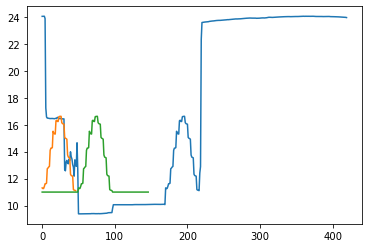

In [64]:
class Transit:
    def __init__(self, date, dec_L, dec_mid, dec_R, horn, noon):
        self.date = date
        self.dec_mid = dec_mid
        self.dec_L = dec_L
        self.dec_R = dec_R
        self.horn = horn
        self.noon = noon
    def get_data(self):
        folder = os.path.join(f"{transit.date}")
        #print(os.listdir(folder))
        datetimes = np.load(os.path.join(folder, 'datetimes.npy'), allow_pickle=True)
        a1p1 = np.load(os.path.join(folder, 'a1p1_bandpass.npy'), allow_pickle=True)
        a1p2 = np.load(os.path.join(folder, 'a1p2_bandpass.npy'), allow_pickle=True)
        a2p1 = np.load(os.path.join(folder, 'a2p1_bandpass.npy'), allow_pickle=True)
        a2p2 = np.load(os.path.join(folder, 'a2p2_bandpass.npy'), allow_pickle=True)
        power_array = np.stack((a2p1, a1p2, a1p1, a2p2))

        # a1p1, a2p2 = WEST, a1p2, a2p1 = EAST

        return datetimes, power_array

#transit_list = [Transit('10th May 2024', 17.81, 17.82, 17.82, 'W', datetime.datetime(2024, 5, 10, 12, 5, 38)),
#                Transit('11th May 2024', 18.06, 18.07, 18.08, 'W', datetime.datetime(2024, 5, 11, 12, 5, 36)),
#                Transit('8th July 2024', 0, 22.38,0, 'E', datetime.datetime(2024, 5, 11, 12, 5, 36))]

transit = Transit('19th July 2024', 0, 20.683044319285145, 0, 'W', datetime.datetime(2024, 7, 19, 12, 15, 34))
time, power = transit.get_data()

print(time.shape)
print(power.shape)

power_total = np.average(power[2], axis=1)
print(power_total.shape)
plt.plot(power_total)

trimmed_power_total = power_total[170:217]
plt.plot(trimmed_power_total)
print(trimmed_power_total)

pwr_baseline = np.hstack(((np.linspace(11,11,50)), trimmed_power_total, (np.linspace(11,11,50))))
plt.plot(pwr_baseline)

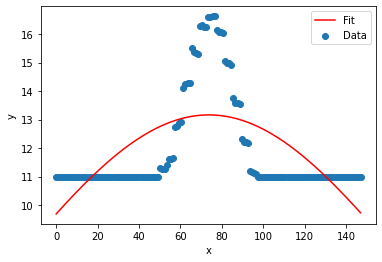

55.474255939996574


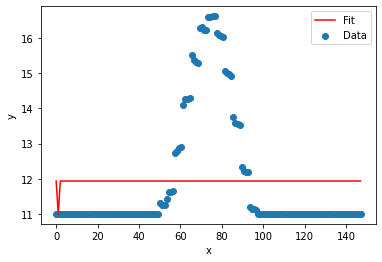

-0.07458565563964555


In [71]:
#TEST DATA
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-(x - mean)**2 / (2 * stddev**2))

x = np.linspace(0, 147, 147)
y = pwr_baseline

#fitting
params, _ = curve_fit(gaussian, x, y, maxfev = 100000)

plt.scatter(x, y, label='Data')
plt.plot(x, gaussian(x, *params), color='red', label='Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

fwhm = 2 * np.sqrt(2 * np.log(2)) * params[2]
print(fwhm*360/(24*60))


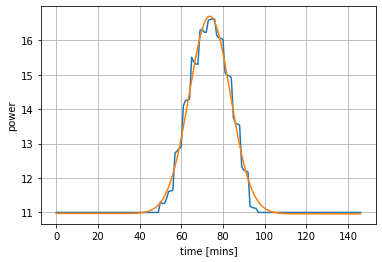

(5.439993184985437,
 0.0662864780699713,
 28.200144750076998,
 0.026200868222869655,
 -0.00010630754239633164,
 0.0003739809325862216,
 10.972736537886572,
 0.03345008905546589)

In [75]:
def harry_plotter(t, p, parameters):
    plt.plot(t, p)
    plt.plot(t, gaussian_with_baseline(t, *parameters))

    plt.xlabel('time [mins]')
    plt.ylabel('power')
    plt.grid()
    #plt.show()
    return

def gaussian_with_baseline(x, a, b, c, d, m):
    return a*np.exp(-((x-b)**2)/(2*(c/(2*np.sqrt(2*np.log(2))))**2)) + m*x + d

def gaussian_with_baseline_fitting(x, y):
    p0 = np.array([np.max(y), np.argmax(y), 98, 10, 1])
    popt, pcov = scipy.optimize.curve_fit(gaussian_with_baseline, x, y, absolute_sigma=0, p0=p0)
    #absolute_sigma=0 to ensure uncertainties reflect the fitting
    return popt, pcov

def calc_beam_width_with_baseline(t, p, dec):
    time_mins = np.array([(i - t[0]).total_seconds() / 60 for i in t])

    para, para_cov = gaussian_with_baseline_fitting(time_mins, p)
    para_err = np.sqrt(np.diag(para_cov))
    
    fwhm_deg_temp = para[2]*np.cos(dec)*360/(23.9345*60)
    fwhm_deg_err_temp = para_err[2]*np.cos(dec)*360/(23.9345*60)

    peak = datetime.timedelta(minutes=para[1]) + t[0]
    peak_err = para_err[1]
    pointing_diff_mins = abs(transit.noon-peak).total_seconds()/60
    pointing_diff_temp = pointing_diff_mins*np.cos(dec)*360/(23.9345*60)
    pointing_diff_err_temp = peak_err*np.cos(dec)*360/(23.9345*60)

    harry_plotter(time_mins, p, para)
    plt.show()

    return fwhm_deg_temp, fwhm_deg_err_temp, pointing_diff_temp, pointing_diff_err_temp, para[-1], para_err[-1], para[-2], para_err[-2]

calc_beam_width_with_baseline(time[0:147], pwr_baseline, transit.dec_mid*np.pi/180)